# Проект "Выявление закономерностей определяющих успешность игры"

Я работаю в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Мне нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируем ли мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Изучение данных из датасета

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

games = pd.read_csv('games.csv')
display(games.info())
display(games.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Согласно документации:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


## Предобработка данных

### Подготовка данных

Сразу сделаем все названия столбцов со строчной буквы:

In [3]:
games.columns = games.columns.str.lower()
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
games.isna().mean()#доли пропусков в данных по столбцам

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

В данных есть пропуски, сделать мы с ними ничего не будем, потому что любое заполнение исказит результаты корреляционного анализа и стат-тестов. Пропуски в rating можно заполнить заглушкой, потому что это категориальная переменная. Заполним хотя бы их.

In [5]:
games.loc[games['rating'].isna(), 'rating'] = 'не определено' #заглушка
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           16715 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
games['user_score'].unique()#посмотрел все столбцы на уникальные, только в таком нашел старнное значение
#'tbd' - to be defined (предстоит определить). Заменим на наны

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [7]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = float('nan')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   object 
 10  rating           16715 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Хотелось бы привести типы к оптимальным, но там наны, поэтому не выйдет. Уберем данные об играх без годов и две строки без названия игры, этим мы отфильтруем меньше 2% данных, ничего важного не потеряем.

In [8]:
games = games.dropna(subset=['name'])
games = games.dropna(subset=['year_of_release'])
games['year_of_release'] = games['year_of_release'].astype(int)# потому что инт поменьше места занимает,
# но здесь вроде не принципиально
games['user_score'] = games['user_score'].astype(float)
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


In [9]:
games.duplicated().sum()

0

Больше ничего путного сделать не сможем, мне кажется. Отправляемся добавлять данные.

### Добавление данных

Нам нужно посчитать суммарные продажи во всех регионах и записать их в отдельный столбец.

In [10]:
games['sales'] = games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
games.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
6900,Harry Potter and the Order of the Phoenix,PS3,2007,Action,0.18,0.03,0.00,0.03,67.0,6.6,E10+,0.24
13061,Venetica,PC,2009,Role-Playing,0.00,0.04,0.00,0.01,61.0,6.8,T,0.05
7293,Over G Fighters,X360,2006,Simulation,0.19,0.01,0.00,0.02,49.0,6.0,T,0.22
7897,The Legend of Heroes: Trails of Cold Steel II,PSV,2014,Role-Playing,0.02,0.02,0.13,0.01,80.0,7.3,T,0.18
4390,Naruto Shippuden: Ultimate Ninja Storm Generat...,X360,2012,Fighting,0.26,0.14,0.01,0.04,74.0,7.2,T,0.45


### Выводы пердобработки данных

Мы устранили некоторые проблемы в данных, поставили заглушку и заменили одно значение на пропуск, убрали данные без года издания, заполнить пропуски везде мы не можем, потому что это повлияет на дальнейший анализ. Добавили общее число продаж по каждой игре(в некоторых случаях, это просто особенное издание, но игра не новая) и проверили дубликаты. Можно приступать к исследовательскому анализу данных.

## Исследовательский анализ данных

### Определение актуального периода и актуальных платформ

Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [11]:
games_per_year = games.groupby(['year_of_release']).agg({'name': 'count'}).reset_index().sort_values(by='name', ascending=False)
games_per_year#.sort_values(by='name', ascending=False)

,year_of_release,name
28,2008,1427
29,2009,1426
30,2010,1255
27,2007,1197
31,2011,1136
26,2006,1006
25,2005,939
22,2002,829
23,2003,775
24,2004,762


Мало игр выпускалось до 1994 года, в 1994 году уже более менее сравнимое с современными показателями количество игр выпускалось, можно брать данные с 94-95 годов, что именно произошло в 94 я не нашел, возможно это стал заполняться предложением отложенный спрос. Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.

Text(0, 0.5, 'Кол-во проданных копий игр\n на платформе(млн. копий)')

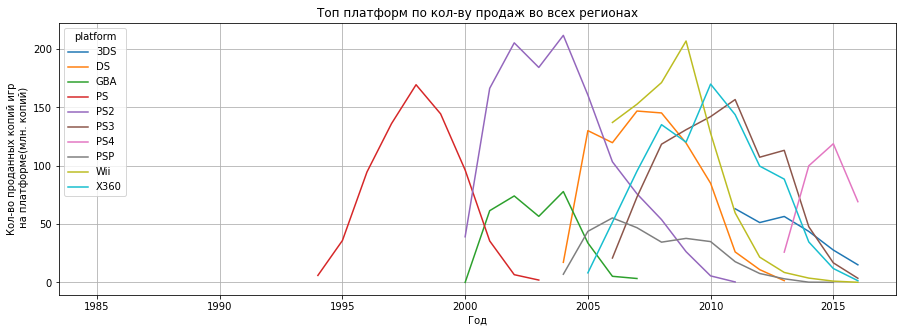

In [12]:
top_10 = games.groupby(['platform']).agg({'sales': 'sum'}).sort_values(by='sales').tail(10).index
games.query('platform in @top_10').pivot_table(index='year_of_release', columns='platform', 
                                               values='sales', aggfunc='sum').plot(figsize=(15,5), grid=True)
plt.title("Топ платформ по кол-ву продаж во всех регионах")
plt.xlabel("Год")
plt.ylabel("Кол-во проданных копий игр\n на платформе(млн. копий)")
#plt.legend('Платформа')

За какой характерный срок появляются новые и исчезают старые платформы? Примерно за 5-10(визуально) лет каждая платформа проходит путь от рождения до смерти, некотрые платформы умирают дольше отстальных, но все равно за пять лет они перестают быть актуальными. По этим данным чуть дольше остальных конкурентноспособными оставались платформы PS3 и X360, мне кажется, это связано с экономическим кризисом в конце нулевых, который сделал разработку новых платформ слишком рискованной и дорогой для Sony и Microsoft(именно они тогда и сейчас рулят рынком, еще наверное Nintendo, но они сделали акцент больше на мобильности). Возьмем данные за соответствующий актуальный период. Актуальный период  мы определили самостоятельно в результате исследования предыдущих вопросов. Кроме того, как видно на графике выше, уже даже современной на 2016 год PS4 идет просадка по продажам, это видели и крупные производители и выпустили модернизированные модели 4ого поколения.

In [13]:
actual_period = games.groupby(['platform','year_of_release']).agg({'sales': 'sum'}).query('platform in @top_10 and sales > 1')
actual_period = actual_period.reset_index().groupby('platform').agg({'year_of_release': 'count'}) # расчитает жизненный период каждой платформы
actual_period.mean() # расчитает сколько в среднем живет успешная платформа 

year_of_release    9.1
dtype: float64

Получается в среднем платформа живет 9 лет. Предположил, что такое число получилось из-за гэймбоя и убрал его, но результат поменялся всего лишь на полгода, даже чуть меньше, поэтому оставим его, он не сильно влияет на среднее, как оказалось. Посмотрим на платформы, которые еще живы и могут приносить прибыль:

In [14]:
#games.query('year_of_release > 2007 and platform in @top_10 and sales > 1')
actual_period

,year_of_release
platform,
3DS,6
DS,10
GBA,7
PS,10
PS2,11
PS3,11
PS4,4
PSP,10
Wii,10


Из прибыльных и живых можно выбрать PS4, GBA уже давно мертв. Странно, что нет XONE, она одного поколения с PS4, видимо у них были провальные первые годы. Можно посмотреть какие платформы на данный момент актуальны.

In [15]:
games_actual_platform = games.groupby(['platform']).agg({'year_of_release': 'min'}).query('year_of_release > (2017-9)')#взял так, потому что прогноз на 2017 и на 10м году жизни платформы мало игр выпускается
#но если поставить 2016-10, то табличка не меняется
games_actual_platform

,year_of_release
platform,
3DS,2011
PS4,2013
PSV,2011
WiiU,2012
XOne,2013


На данный момент имеем 5 актуальных платформ, одна из них находится в нашем топе по продажам. Посмотрим продажи каждой платформы детальнее.

### Детальный просмотр актуальных платформ

Text(0, 0.5, 'Кол-во проданных копий игр\n на платформе(млн. копий)')

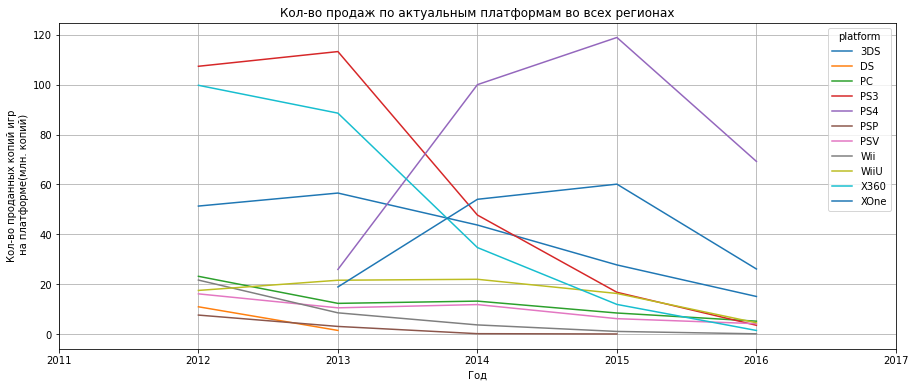

In [16]:
#top_10
#games_actual_platform_index = games_actual_platform.index
games.query('year_of_release >= 2012').pivot_table(index='year_of_release',
                                columns='platform', values='sales', aggfunc='sum').plot(figsize=(15,6), grid=True)
plt.title("Кол-во продаж по актуальным платформам во всех регионах")
plt.xlim(2011,2017)
plt.xlabel("Год")
plt.ylabel("Кол-во проданных копий игр\n на платформе(млн. копий)")

Видно падение у всех платформ примерно одинаковое, кроме свежих XONE, PS4 и их предшественников X360, PS3 и 3DS. WiiU и PSV так и не смогли выйти на уровень сравнимый с XONE, PS4, X360, PS3 и 3DS. PSP держалась аж до 2015 года, но там продажи были очень низкими.

Потенциально прибыльными можно считать платформы: 3DS, XONE, PS4. Но у них продажи падают. 3DS стала мало кому нужна после выхода XONE и PS4, продажи на ней показывают постоянное падение после выхода в свет XONE и PS4. У самих же XONE и PS4 продажи росли до 2016 года, в 16ом упали, мне кажется, это связано с релизом PS4 Slim, Pro и XONE S, X. Хотя игры подходят для любой модели этого поколения, тут у же у меня вопросы к сбору данных, возможно в 2016ом некоторые покупки были записаны уже к свежим платформам, хотя они подходят и для XONE, PS4. По нашим данным самыми перспективными будем считать XONE, PS4. PC же никогда не устаревает, но продажи по ней тоже очень малы.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам и опишем результат.

Text(0, 0.5, 'Кол-во проданных копий \n игры для платформы(млн.)')

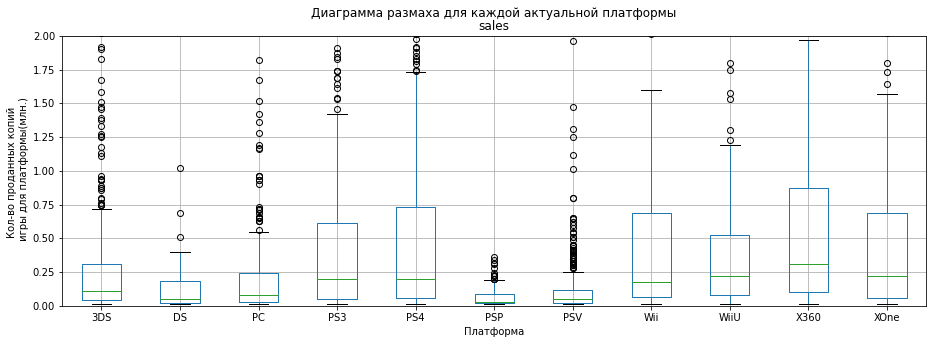

In [17]:
actual_games = games.query('year_of_release >= 2012')
actual_games.boxplot(column='sales', by='platform', figsize=(15,5))
plt.ylim(0,2)
plt.suptitle('Диаграмма размаха для каждой актуальной платформы')
plt.xlabel("Платформа")
plt.ylabel("Кол-во проданных копий \n игры для платформы(млн.)")

По диаграмме размаха можно сказать, что Sony и Microsoft выбрали разые пути перехода на новые поколения. Microsoft сделали ставку на поддержке сатрой консоли и поэтому их продажи на новом поколении ниже, чем на старом, а Sony наоборот сделлал ставку на новое поколение. Wii обладает почти теми же парамметрами. Игры на PSV показывают себя схоже с играми на PC, почти одинаковая медиана(чуть меньше 0,1 млн. копий) ящик же и третья квантиль у PC чуть больше, чем у PSV. У 3DS дела обстоят средне между XONE, PS4 и PC, PSV. Медиана 0,1 млн. копий, ящик от 0,05 млн. до 0,3 млн. копий, а третья квантиль равна 0,7 млн. копий. Выбросы на международных платформерах(XOne, PS4 и WiiU) начинаются с больших значений. На X360 выбросы начинаются с 2 млн. копий, на PS4 выбросы начинаются со значения в 1,75 млн. проданных копий, для XOne с 1,5 млн. копий,PS3 показывает такие же параметры, как и XOne, на WiiU они начинаются со значений 1,2 млн. копий, потом у нас идет 3DS, у него выбросы начинаются с 0,75 млн. копий, на ПК у нас выбросы идут с 0,4 млн. копий, а для PSV с 0,3 млн. копий.

PSP оказалась провальнее своего наследника, 3DS успешнее DS, Wii тоже оказалась успешнее наследницы - WiiU. У PS3, XOne, PS4, X360 примерно равные медианы по количеству проданных копий, все около 0,25млн. Можно сказать лидеры индустрии ими же и остались при смене поколения, а выбросы у них тоже примерно с одинаковых значений начинаются, единственное - имеется отличие, которое я описал в предыдущем абзаце. 

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

Коэф. корреляции для связи оценки пользователей и кол-во проданных копий -0.03195711020455644
Коэф. корреляции для связи оценки критиков и кол-во проданных копий 0.40656790206178123


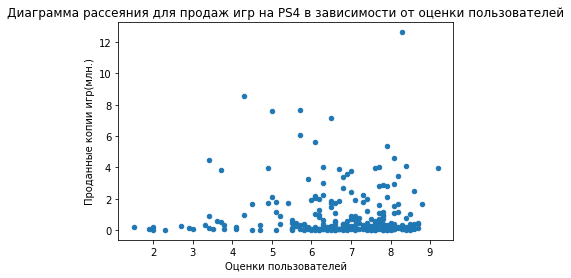

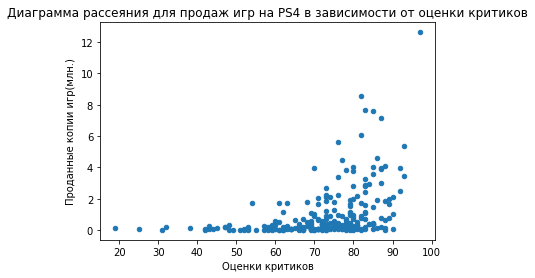

In [18]:
def correl(df, platforma):
    df.query('platform == @platforma').plot(x='user_score', y='sales', kind='scatter')
    plt.title(f"Диаграмма рассеяния для продаж игр на {platforma} в зависимости от оценки пользователей")
    plt.xlabel("Оценки пользователей")
    plt.ylabel("Проданные копии игр(млн.)")
    plt.show
    df.query('platform == @platforma').plot(x='critic_score', y='sales', kind='scatter')
    plt.title(f"Диаграмма рассеяния для продаж игр на {platforma} в зависимости от оценки критиков")
    plt.xlabel("Оценки критиков")
    plt.ylabel("Проданные копии игр(млн.)")
    plt.show
    print('Коэф. корреляции для связи оценки пользователей и кол-во проданных копий', 
          df.query('platform == @platforma')['user_score'].corr(df.query('platform == @platforma')['sales']))
    print('Коэф. корреляции для связи оценки критиков и кол-во проданных копий', 
          df.query('platform == @platforma')['critic_score'].corr(df.query(f'platform == @platforma')['sales']))
        
correl(actual_games, "PS4")

Как можно видеть, по коэффициенту корреляции(по диаграмме лично мне менее очевидно это), что прямая связь между оценками критиков и количеством проданных копий, она не очень сильная, но численно явно есть. А вот между оценками пользователей и количеством проданных копий связи не замечается, она около нуля. Посмотрим корреляцию по другим платформам.

Коэф. корреляции для связи оценки пользователей и кол-во проданных копий 0.19758263411038593
Коэф. корреляции для связи оценки критиков и кол-во проданных копий 0.3208028695360785


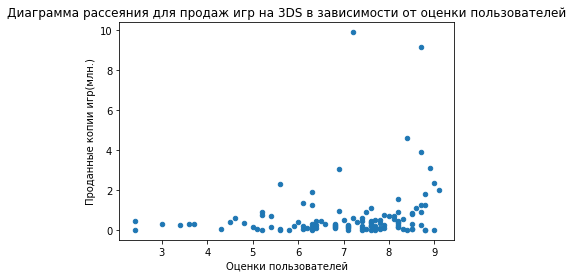

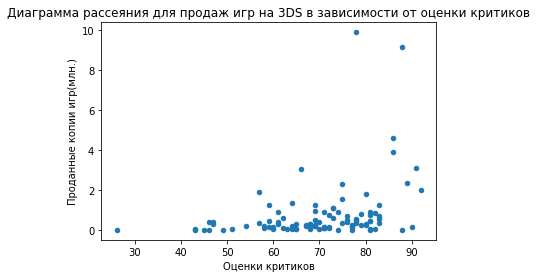

In [19]:
correl(actual_games, "3DS")

Здесь у нас уже есть зависимость кол-ва проданных копий от оценок пользователей, но она все еще меньше, чем зависимость кол-ва проданных копий от оценок экспертов. Коэф. корреляции(по оцекам критиков) здесь почти такой же, как и у PS4. 

Коэф. корреляции для связи оценки пользователей и кол-во проданных копий -0.12186747630735571
Коэф. корреляции для связи оценки критиков и кол-во проданных копий 0.23724324311567904


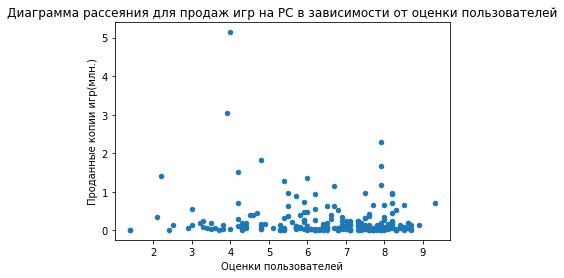

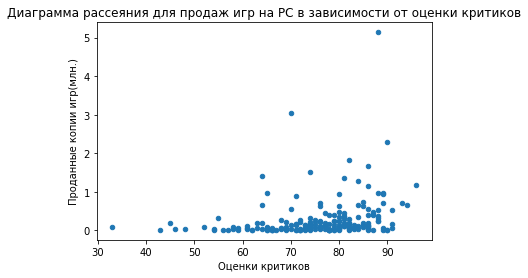

In [20]:
correl(actual_games, "PC")

На PC зависимость от оценок очень маленькая, и опять же оценки критиков сильнее влияют на продажи, чем оценки пользователей, но здесь коэф. корреляции(по оценкам критиков) в два раза меньше, чем в двух предыдущих примерах.

Коэф. корреляции для связи оценки пользователей и кол-во проданных копий -0.004339437514314884
Коэф. корреляции для связи оценки критиков и кол-во проданных копий 0.0944878992931617


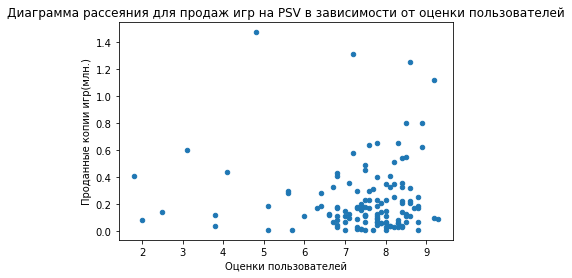

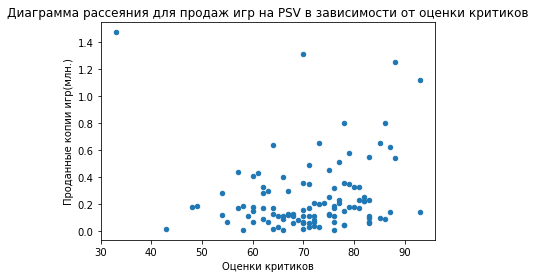

In [21]:
correl(actual_games, "PSV")

PSV показывает еще меншьшую зависимость от мнения критиков и пользователей, можно даже сказать, что зависимоти нет.

Коэф. корреляции для связи оценки пользователей и кол-во проданных копий 0.40021902021486194
Коэф. корреляции для связи оценки критиков и кол-во проданных копий 0.34837976012017496


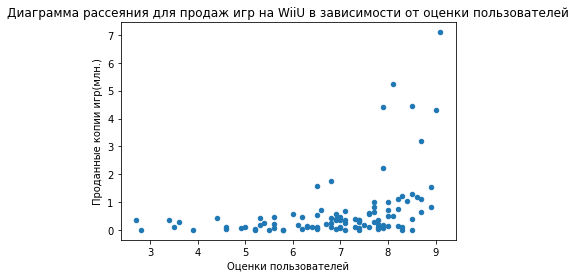

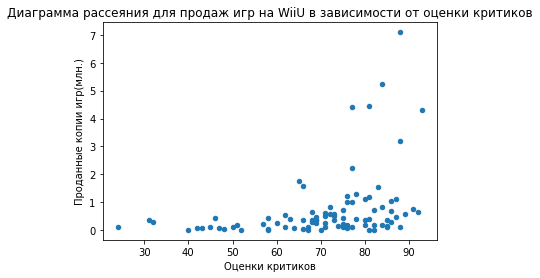

In [22]:
correl(actual_games, "WiiU")

А вот на WiiU ситуация обратная, оценка критиков меньше влияет на продажи, а оценки пользователей здесь влияют так же, как оценки критиков игр на PS4 и 3DS.

Коэф. корреляции для связи оценки пользователей и кол-во проданных копий -0.06892505328279418
Коэф. корреляции для связи оценки критиков и кол-во проданных копий 0.41699832800840153


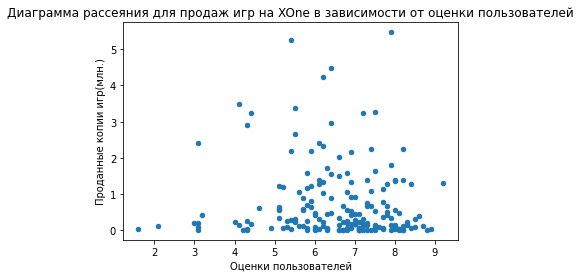

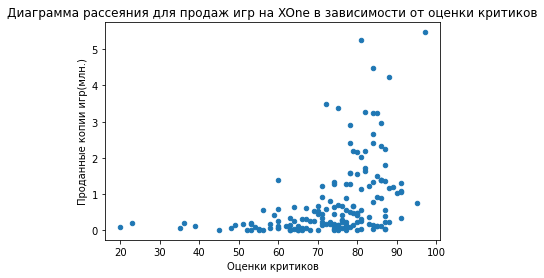

In [23]:
correl(actual_games, "XOne")

На XOne ситуация такая же, как и на PS4. Одно поколение, конкуренты, одни тенденции.

Коэф. корреляции для связи оценки пользователей и кол-во проданных копий -0.005143522887113829
Коэф. корреляции для связи оценки критиков и кол-во проданных копий 0.33149725926295903


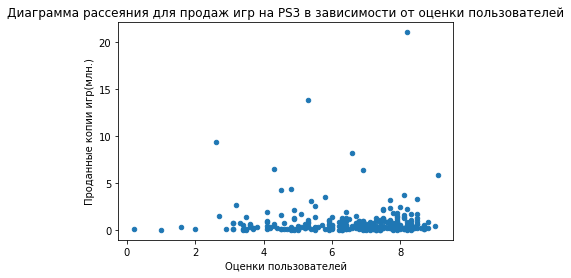

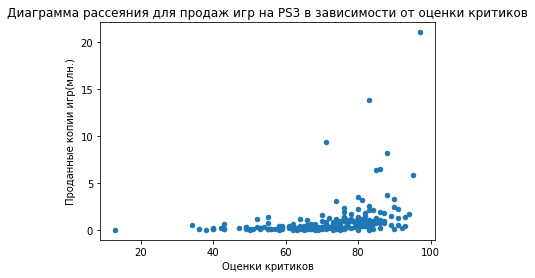

In [24]:
correl(actual_games, "PS3")

Видна средняя зависимость кол-ва проданных копий от оценок критиков. От оценок пользователей можно сказать зависимости нет.

Коэф. корреляции для связи оценки пользователей и кол-во проданных копий 0.006163978646213359
Коэф. корреляции для связи оценки критиков и кол-во проданных копий 0.36057348885073387


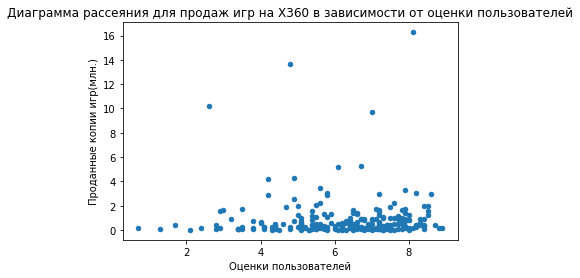

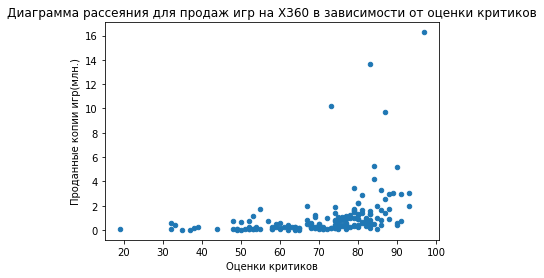

In [25]:
correl(actual_games, "X360")

Опять видна зависимость от отзывов критиков, а от оценок пользователй тоже не зависит.

Коэф. корреляции для связи оценки пользователей и кол-во проданных копий -0.8023020619393209
Коэф. корреляции для связи оценки критиков и кол-во проданных копий nan


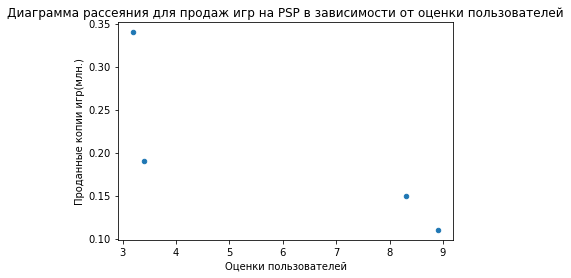

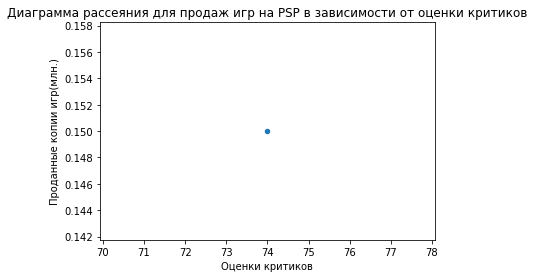

In [26]:
correl(actual_games, "PSP")

Здесь мало данных, поэтому результатов будем считать, что нет.

Коэф. корреляции для связи оценки пользователей и кол-во проданных копий 0.88270872757644
Коэф. корреляции для связи оценки критиков и кол-во проданных копий nan


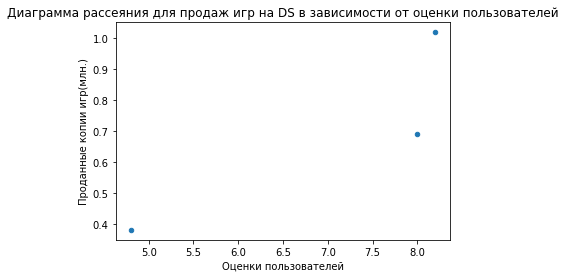

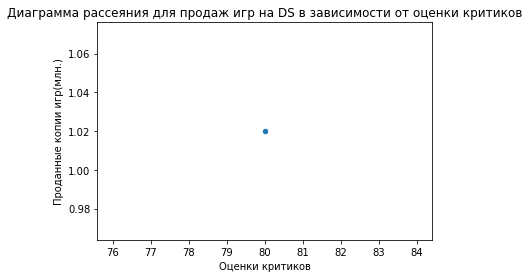

In [27]:
correl(actual_games, "DS")

Здесь мало данных, поэтому результатов будем считать, что нет.

Коэф. корреляции для связи оценки пользователей и кол-во проданных копий 0.29619680007479526
Коэф. корреляции для связи оценки критиков и кол-во проданных копий -0.42434130110774954


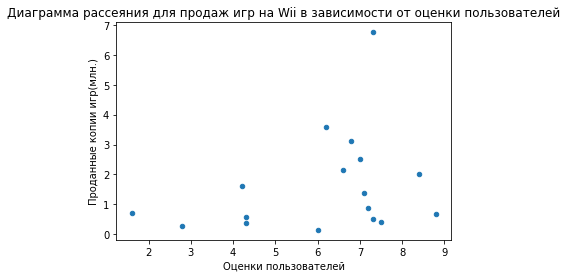

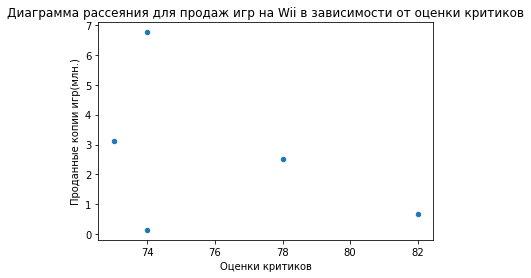

In [28]:
correl(actual_games, "Wii")

И здесь данных маловато, делать какие-то выводы не будем.

Посмотрим на распределение по жанрам.

<function matplotlib.pyplot.show(close=None, block=None)>

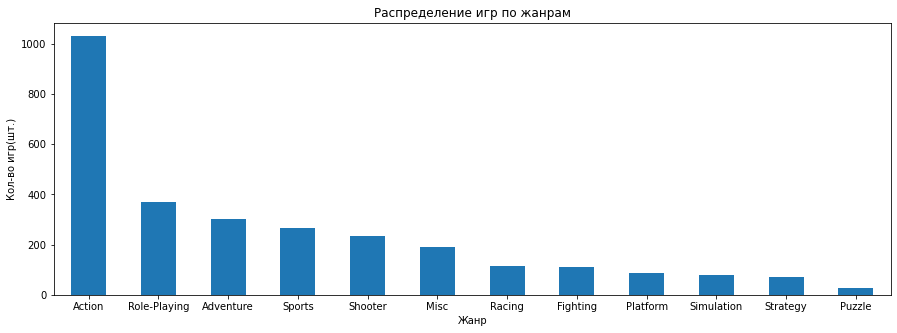

In [29]:
actual_genres = actual_games.groupby(['genre']).agg({'name': 'count'}).sort_values(by='name', ascending=False).reset_index()
ax = actual_genres.plot.bar(x='genre', y='name', rot=0, figsize=(15,5), legend=None)
plt.title("Pаспределение игр по жанрам")
plt.xlabel("Жанр")
plt.ylabel("Кол-во игр(шт.)")
plt.show

Наибольшее кол-во игр в жанре экшн, их больше, чем сумма игр двух его преследователей. Все остальные жанры сильно отстают от лидера и в целом находятся рядом друг с другом.

<function matplotlib.pyplot.show(close=None, block=None)>

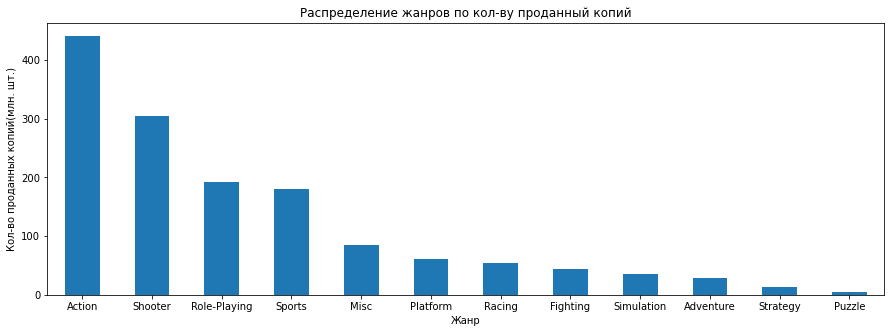

In [30]:
actual_genres = actual_games.groupby(['genre']).agg({'sales': 'sum'}).sort_values(by='sales', ascending=False).reset_index()
ax = actual_genres.plot.bar(x='genre', y='sales', rot=0, figsize=(15,5), legend=None)
plt.title("Pаспределение жанров по кол-ву проданный копий")
plt.xlabel("Жанр")
plt.ylabel("Кол-во проданных копий(млн. шт.)")
plt.show

Тут можно заметить, что у наши лидеры в распределении игр по жанрам и здесь лидеры, видимо здесь есть взаимосвязь. Жанры-аутсайдеры по кол-ву игр, а именно головоломки и стратегии, тут тоже не показывает себя в первых рядах и находятся на тех же позициях, что и в рейтинге по кол-ву игр в жанре.

<function matplotlib.pyplot.show(close=None, block=None)>

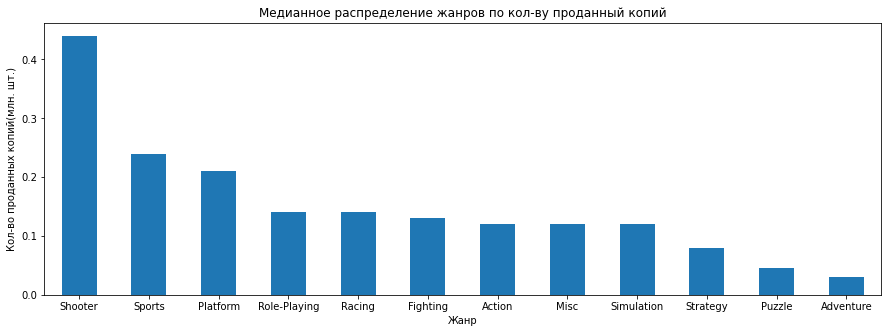

In [31]:
actual_genres = actual_games.groupby(['genre']).agg({'sales': 'median'}).sort_values(by='sales', ascending=False).reset_index()
ax = actual_genres.plot.bar(x='genre', y='sales', rot=0, figsize=(15,5), legend=None)
plt.title("Медианное распределение жанров по кол-ву проданный копий")
plt.xlabel("Жанр")
plt.ylabel("Кол-во проданных копий(млн. шт.)")
plt.show

По медианным продажам лидеры: шутеры, платформеры и спортивные игры. Из старых лидеров остались только шутеры и спортивные игры.

### Выводы исследовательского анализа

Мы определили актуальный период и актуальные платформы, определили характерный срок, за который появляются новые и исчезают старые платформы, определили какие платформы лидируют по продажам. Выберали несколько потенциально прибыльных платформ(PS4, PS3 и XOne, X360), описали глобальные продажи игр в разбивке по платформам, посмотрели, как влияют на продажи внутри одной платформы отзывы пользователей и критиков, построили диаграмму рассеяния и посчитали корреляцию между отзывами и продажами. Соотнесли выводы с продажами игр на других платформах. И наконец, посмотрели на общее распределение игр по жанрам, выделили жанры с высокими и низкими продажами. Медианные продажи в лидерах остался только шутер и спортивные игры.

## Портрет пользователя каждого региона <a id='portret'></a>

Определим для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5) и опишем различия в долях продаж.

,na_sales,procent
platform,,
X360,140.05,23.698326
PS4,108.74,18.400257
PS3,103.38,17.493274
XOne,93.12,15.757145
3DS,55.31,9.359189


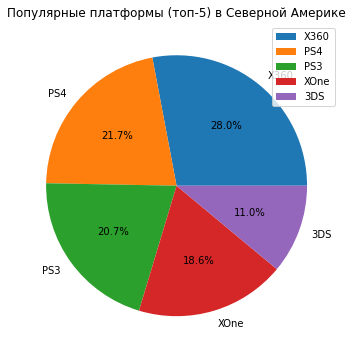

In [32]:
def doli(df, _sales, region, ind, index):
    na_platform = df.pivot_table(index=ind, values=_sales, aggfunc='sum').sort_values(by=_sales, ascending=False)
    na_platform['procent'] =  na_platform.loc[:, _sales]/(na_platform[_sales].sum())*100
    na_platform.head(5).plot.pie(y=_sales,subplots=True, figsize=(15, 6), autopct='%1.1f%%')
    plt.title(f"Популярные {index} (топ-5) в {region}")
    plt.ylabel(None)
    plt.show
    display(na_platform.head(5))
doli(actual_games, 'na_sales', 'Северной Америке', 'platform','платформы')

В Северной Америке наибольшей популярностью пользуется платформа X360, дальше почти одинаковую долю занимают PS4 и PS3(каждая по пятой части от всех продаж), 16% приходится на игры платформы XOne и замыкает наш топ-5 3DS c почти 9% всего рынка. 

,eu_sales,procent
platform,,
PS4,141.09,27.838286
PS3,106.86,21.084409
X360,74.52,14.703445
XOne,51.59,10.179156
3DS,42.64,8.413243


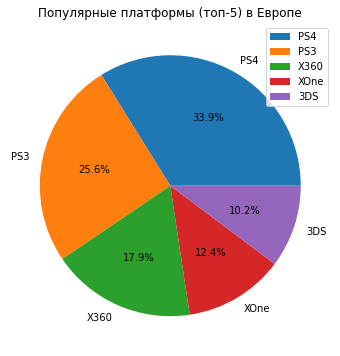

In [33]:
doli(actual_games, 'eu_sales', 'Европе', 'platform','платформы')

В Европе наибольшей популярностью пользуются платформы PS3 и PS4(на них приходится половина всех продаж), дальше 15% рынка занимают игры на платформе X360, потом XOne c 10% рынка и опять замыкает наш топ-5 3DS c почти 8% всех проданных игр. 

,jp_sales,procent
platform,,
3DS,87.79,45.586250
PS3,35.29,18.324852
PSV,21.04,10.925330
PS4,15.96,8.287465
WiiU,13.01,6.755634


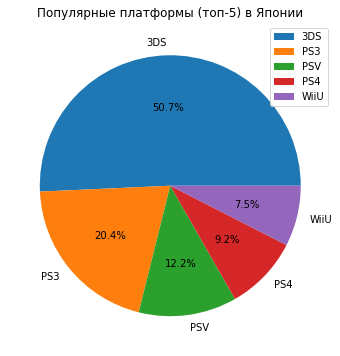

In [34]:
doli(actual_games, 'jp_sales', 'Японии', 'platform','платформы')

В Японии дела обстоят иначе. Самой популярной платформой является 3DS, она занимает 45% рынка, дальше идет PS3(18%), PSV(11%) и PS4(8%). WiiU интересна 7% пользователей из Японии.

Определим самые популярные жанры (топ-5) и попробуем пояснить разницу.

,na_sales,procent
genre,,
Action,177.84,30.092898
Shooter,144.77,24.497013
Sports,81.53,13.795963
Role-Playing,64.00,10.829653
Misc,38.19,6.462257


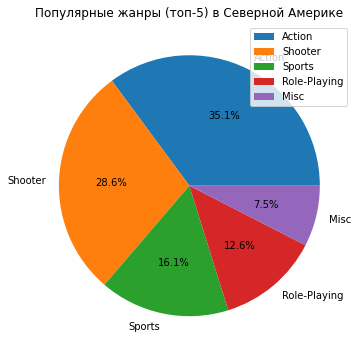

In [35]:
doli(actual_games, 'na_sales', 'Северной Америке', 'genre','жанры')

Самые популярные жанры в Северной Америке - экшн и шутер, почти 14% проданных игр - спортивные, 11 и 6 процентов рынка приходятся на ролевые игры и "разное" соответственно.

,eu_sales,procent
genre,,
Action,159.34,31.439170
Shooter,113.47,22.388619
Sports,69.09,13.632059
Role-Playing,48.53,9.575392
Racing,27.29,5.384555


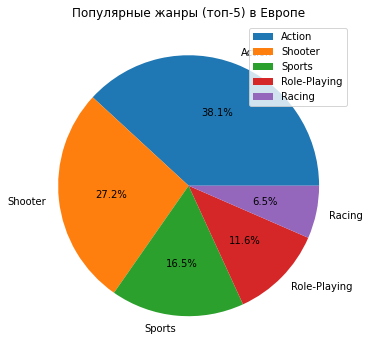

In [36]:
doli(actual_games, 'eu_sales', 'Европе', 'genre','жанры')

В Европе предпочтения точно такие же, как и в Северной Америке. Только на последнем месте в топе находятся гонки.

,jp_sales,procent
genre,,
Role-Playing,65.44,33.980683
Action,52.80,27.417177
Misc,12.86,6.677744
Simulation,10.41,5.405546
Fighting,9.44,4.901859


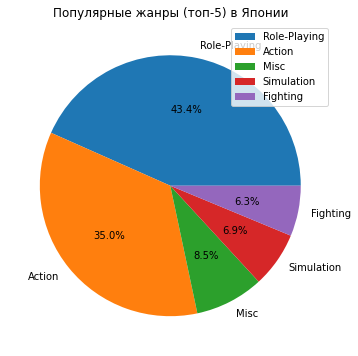

In [37]:
doli(actual_games, 'jp_sales', 'Японии', 'genre','жанры')

А вот в Японии очень популярны ролевые игры(34%), четвертую часть всех игр занимают экшены. "Разное", спорт и приключения заняли последние строчки нашего топа. 

Посомтрим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

Text(0, 0.5, 'Кол-во проданных копий \n игры для категории(млн.)')

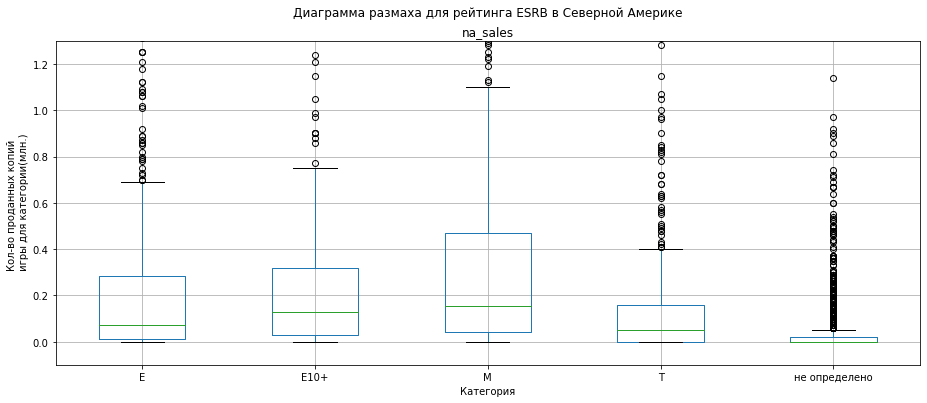

In [38]:
actual_games.boxplot(column='na_sales', by='rating',  figsize=(15, 6))
plt.ylim(-0.1,1.3)
plt.suptitle('Диаграмма размаха для рейтинга ESRB в Северной Америке')
plt.xlabel("Категория")
plt.ylabel("Кол-во проданных копий \n игры для категории(млн.)")

Text(0, 0.5, 'Кол-во проданных копий \n игры для категории(млн.)')

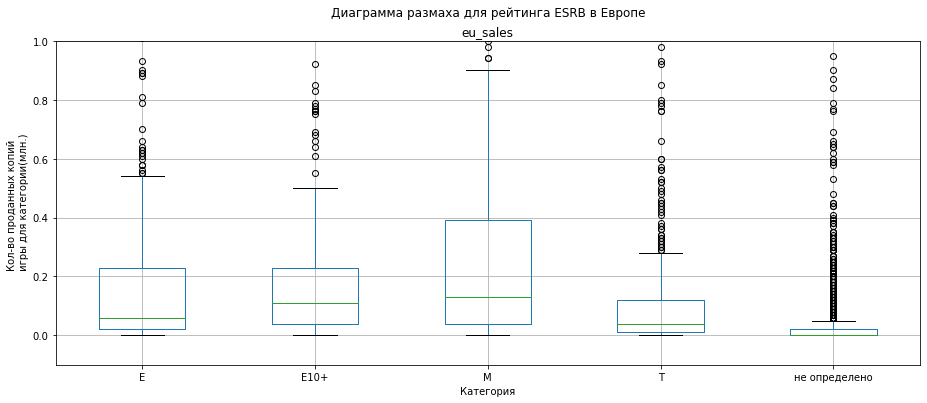

In [39]:
actual_games.boxplot(column='eu_sales', by='rating',  figsize=(15, 6))
plt.ylim(-0.1,1)
plt.suptitle('Диаграмма размаха для рейтинга ESRB в Европе')
plt.xlabel("Категория")
plt.ylabel("Кол-во проданных копий \n игры для категории(млн.)")

Text(0, 0.5, 'Кол-во проданных копий \n игры для категории(млн.)')

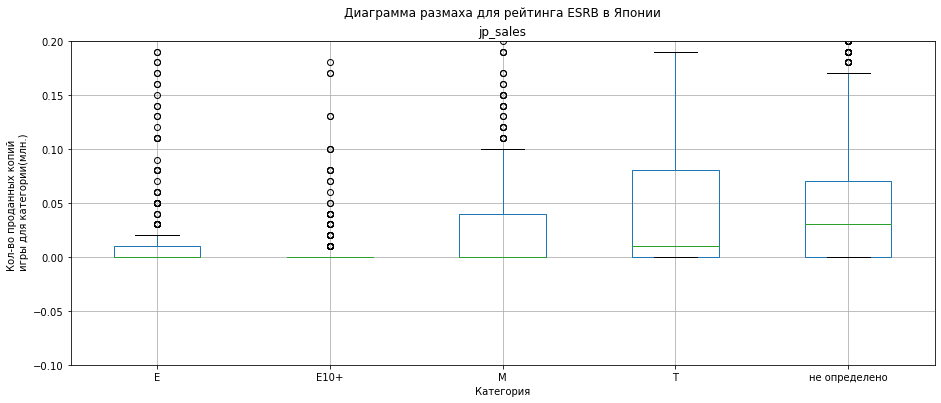

In [40]:
actual_games.boxplot(column='jp_sales', by='rating',  figsize=(15, 6))
plt.ylim(-0.1,0.2)
plt.suptitle('Диаграмма размаха для рейтинга ESRB в Японии')
plt.xlabel("Категория")
plt.ylabel("Кол-во проданных копий \n игры для категории(млн.)")

Для потребителей из Японии рейтинг ESRB ничего не значит, а вот для потребителей из Европы и Северной Америки он значит немного больше, чем ничего, но продажи все равно какие-то маленькие. Мне кажется, пользователи из Японии ориентируются на какой-то свой локальный рейтинг, потому что игры интересные им, не интересны остальным регионам.

### Вывод портрета пользователя

Мы опроеделили самые популярные платформы (топ-5) и описали различия в долях продаж, а также описали самые популярные жанры (топ-5). Потребители из Японии показали свои необычные предпочтения как в платформах, так и в жанрах игр. Рейтинг ESRB на потребителей Японии никак не влияет и чуть сильнее влияет на потребителей Европы и Северной Америки.

## Проверка гипотез

Проверим первую гипотезу: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
Нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства, альтернативная будет отрицанием нулевой. Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind() 
Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC равны.
Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [41]:
actual_games = actual_games.dropna(subset=['user_score'])#так как для теста нельзя заполнять данные, придется удалить наны
actual_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1531 entries, 16 to 16692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1531 non-null   object 
 1   platform         1531 non-null   object 
 2   year_of_release  1531 non-null   int32  
 3   genre            1531 non-null   object 
 4   na_sales         1531 non-null   float64
 5   eu_sales         1531 non-null   float64
 6   jp_sales         1531 non-null   float64
 7   other_sales      1531 non-null   float64
 8   critic_score     1297 non-null   float64
 9   user_score       1531 non-null   float64
 10  rating           1531 non-null   object 
 11  sales            1531 non-null   float64
dtypes: float64(7), int32(1), object(4)
memory usage: 149.5+ KB


In [42]:
(
    actual_games.query('platform == "XOne" or platform == "PC"')
    .groupby('platform').agg({'user_score': ['mean', 'std', 'var', 'count']})
)

user_score                          
               mean       std       var count
platform                                     
PC         6.428641  1.664465  2.770444   206
XOne       6.521429  1.380941  1.906997   182

In [43]:

sample_1 = actual_games[actual_games['platform']=='XOne']['user_score']
sample_2 = actual_games[actual_games['platform']=='PC']['user_score']

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2, equal_var = False)#выбрал equal_var = False, потому что 
#генеральные у пк и бокса точно разного размера(пк на рынке очень давно), дисперсии выборок тоже неравны, но близки,
#тут я немного засомневался. Но я проверю и так и так(проверил, отвергает при любом equal_var)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


Видимо, средние пользовательские рейтинги платформ Xbox One и PC и правда равны.

Проверим вторую гипотезу: средние пользовательские рейтинги жанров Action и Sports разные.
Нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства, альтернативная будет отрицанием нулевой. Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind() 
Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports равны.
Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports разные.

In [44]:
(
    actual_games.query('genre == "Action" or genre == "Sports"')
    .groupby('genre').agg({'user_score': ['mean', 'std', 'var', 'count']})
)    

user_score                          
             mean       std       var count
genre                                      
Action   6.825048  1.374440  1.889084   523
Sports   5.455897  1.738646  3.022890   195

In [45]:

sample_1 = actual_games[actual_games['genre']=='Action']['user_score']
sample_2 = actual_games[actual_games['genre']=='Sports']['user_score']

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2, equal_var = False)#выбрал equal_var = False, потому что 
#генеральные у Sports и Action точно разного размера(Action жанр самый популярный), дисперсии выборок тоже неравны,
#но я проверю и так и так(проверил, отвергает при любом equal_var)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


Видимо, средние пользовательские рейтинги жанров Action и Sports действительно разные.

### Вывод проверки гипотез

Мы проверили две гипотезы, одну отвергнули и одну не получилось отвергнуть, а это значит, что средние пользовательские рейтинги платформ Xbox One и PC и правда равны и средние пользовательские рейтинги жанров Action и Sports действительно разные. В обоих проверках был критический уровень значимости равен 5%, если его взять больше в проверках, то результат останется тем же, потому что p-значение в ней почти нулевое, а вот если в первой проверке взять его 10%, то результат поменяется. Останемся при таком уровне значимости, потому что его достаточно для проверки гипотезы(нас не просили проверить "грубо", но будем иметь это ввиду). Попробовал с разным параметром equal_var, результат тот же. 

## Вывод

Мы проделали большу работу: открыли файл с данными и изучили общую информацию, заменили названия столбцов (привели к нижнему регистру), обработали пропуски, посчитали суммарные продажи во всех регионах, провели исследовательский анализ данных, а именно:
- Посмотрели, сколько игр выпускалось в разные годы.
- Посмотрели, как менялись продажи по платформам. Выбрали платформы с наибольшими суммарными продажами и построили распределение по годам. Определили характерный срок смерти платформы.
- Взяли данные за соответствующий актуальный период. Актуальный период определили самостоятельно в результате исследования предыдущих вопросов.
- Определили, какие платформы лидируют по продажам.
- Построили график «ящик с усами» по глобальным продажам игр в разбивке по платформам.
- Посмотрели, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построили диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.
- Соотнесли выводы с продажами игр на других платформах.
- Посмотрели на общее распределение игр по жанрам.

Дальше мы составили портрет пользователя каждого региона и проверили гипотезы, одну отвергнули и одну не получилось отвергнуть.
Нам нужно было выявить определяющие успешность игры закономерности. Успешность игры зависит от региона, например в Японии очень любят ролевые игры и экшены, а в Америке и Европе больше пользователям нравятся экшены, шутеры и спортивные игры, в той же Японии почти никто не пользуется X360 и Xbox One, в основном 3DS, PS3, PSV и PS4. На момент проекта(2016год) вышли консоли нового поколения или подпоколения, но они поддерживали игры поколения предыдущего(PS4 и Xbox One). Перспективные платформы в Европе и Северной Америке PS4 и Xbox One, а на данный момент популярны PS3(больше в Еаропе) и X360(больше в Америке), в Японии 3DS и PS3, в перспективе подтянется PS4(будет лиелером в Европе и возможно в Японии, хотя японцам больше видимо нужна мобильность платформы). На многих платформах отзывы критиков взаимосвязаны с продажами, кроме WiiU, на ней наоборот больше влияют отзывы пользователей. Рейтинг ESRB немного влияет на продажи в Америке и Европе, а вот в Японии всем все равно на этот рейтинг, потому что у них есть свой. Более детально этот прогноз лучше смотреть в разделе ["Портрет пользователя каждого региона"](#portret).